In [1]:
%pip install -r ../requirements.txt


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /anaconda/envs/azureml_py310_sdkv2/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import numpy as np
import itertools
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import xgboost as xgb
import shap
from sklearn.metrics import mean_absolute_error
import mlflow

# Load environment variables
load_dotenv()
SYNAPSE_CONN_STRING = os.getenv("SYNAPSE_CONN_STRING")

# Load data from Synapse
engine = create_engine(SYNAPSE_CONN_STRING, connect_args={'timeout': 60})
with engine.connect() as connection:
    df = pd.read_sql_query(text("SELECT * FROM v_financials_quarterly"), connection)

print("Data loaded successfully.")

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data loaded successfully.


In [3]:
# Convert date columns to datetime objects
df['prediction_quarter'] = pd.to_datetime(df['prediction_quarter'])
df['report_date'] = pd.to_datetime(df['report_date'])

# Sort the data chronologically per company
df.sort_values(by=['ticker', 'prediction_quarter'], inplace=True)
df.reset_index(drop=True, inplace=True)

print("Data sorted and prepared.")

Data sorted and prepared.


In [4]:
# Create derived features
df['shareholder_equity'] = df['assets'] - df['liabilities']

# Create the target variable
df['target_revenue_next_q'] = df.groupby('ticker')['revenues'].shift(-1)

# Create time-based features
df['quarter'] = df['prediction_quarter'].dt.quarter
df['year'] = df['prediction_quarter'].dt.year

# Define and create lag/rolling features
features_to_engineer = {
    'revenues': {'lags': [1, 2, 3, 4], 'rolling_avg': [4]},
    'net_income': {'lags': [2, 3, 4], 'rolling_avg': [4]},
    'research_and_development_expense': {'lags': [4, 5, 6, 7, 8]},
    'selling_general_and_administrative_expense': {'lags': [1, 2], 'rolling_avg': [4]},
    'assets': {'lags': [2, 3, 4]},
    'liabilities': {'lags': [2, 3, 4]},
    'shareholder_equity': {'lags': [2, 3, 4]},
    'gdp': {'lags': [1, 2]},
    'cpi': {'lags': [1]},
    'unemployment': {'lags': [1, 2]}
}

for col, params in features_to_engineer.items():
    if 'lags' in params:
        for lag in params['lags']:
            df[f'{col}_lag_{lag}'] = df.groupby('ticker')[col].shift(lag)
    if 'rolling_avg' in params:
        for window in params['rolling_avg']:
            df[f'{col}_rolling_avg_{window}'] = df.groupby('ticker')[col].transform(lambda x: x.rolling(window=window).mean())

df['revenue_seasonal_diff'] = df['revenues'] - df['revenues_rolling_avg_4']

print("Feature engineering complete.")

Feature engineering complete.


In [5]:
# Drop rows with nulls created by feature engineering
df_model = df.dropna().copy()
df_model.set_index('prediction_quarter', inplace=True)

# Define X and y, ensuring y contains the ticker for alignment
feature_cols = [c for c in df_model.columns if '_lag_' in c or '_rolling_avg_' in c or '_seasonal_diff_' in c]
time_cols = ['year', 'quarter']
X = df_model[feature_cols + time_cols].copy()
y = df_model[['target_revenue_next_q', 'ticker']]
X['quarter'] = X['quarter'].astype('category')

# --- Dynamic Train-Validation-Test Split ---

# Find the last date in our feature set
last_date = X.index.max()

# Define the split points relative to the last date
# The test set will be the most recent full year (4 quarters)
validation_end_date = last_date - pd.DateOffset(years=1)
# The validation set will be the year before the test set
train_end_date = validation_end_date - pd.DateOffset(years=1)

print(f"Latest data point: {last_date.date()}")
print(f"Splitting training data at: {train_end_date.date()}")
print(f"Splitting validation data at: {validation_end_date.date()}")

# Create the training set
X_train = X[X.index <= train_end_date]
y_train = y[y.index <= train_end_date]

# Create the validation set
X_val = X[(X.index > train_end_date) & (X.index <= validation_end_date)]
y_val = y[(X.index > train_end_date) & (X.index <= validation_end_date)]

# Create the test set
X_test = X[X.index > validation_end_date]
y_test = y[X.index > validation_end_date]

print(f"\nTraining set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Latest data point: 2025-04-01
Splitting training data at: 2023-04-01
Splitting validation data at: 2024-04-01

Training set size: 192
Validation set size: 12
Test set size: 12


In [5]:
# Define Hyperparameter Grid
param_grid = { 'n_estimators': [500, 1000], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5], 'subsample': [0.7, 1.0] }
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
best_score = float('inf')
best_params = None

print(f"Starting hyperparameter search across {len(all_params)} combinations...")
for params in all_params:
    model = xgb.XGBRegressor(objective='reg:squarederror', enable_categorical=True, random_state=42, **params)
    model.fit(X_train, y_train['target_revenue_next_q'], verbose=False)
    val_preds = model.predict(X_val)
    score = mean_absolute_error(y_val['target_revenue_next_q'], val_preds)
    if score < best_score:
        best_score = score
        best_params = params

print("\nHyperparameter tuning complete.")
print(f"Best MAE on Validation Set: ${best_score:,.2f}")
print("Best hyperparameters found:", best_params)

Starting hyperparameter search across 16 combinations...

Hyperparameter tuning complete.
Best MAE on Validation Set: $4,061,859,877.33
Best hyperparameters found: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.7}



Final Model MAE on Test Set: $8,513,188,800.00

SHAP Summary Plot (Feature Importance):


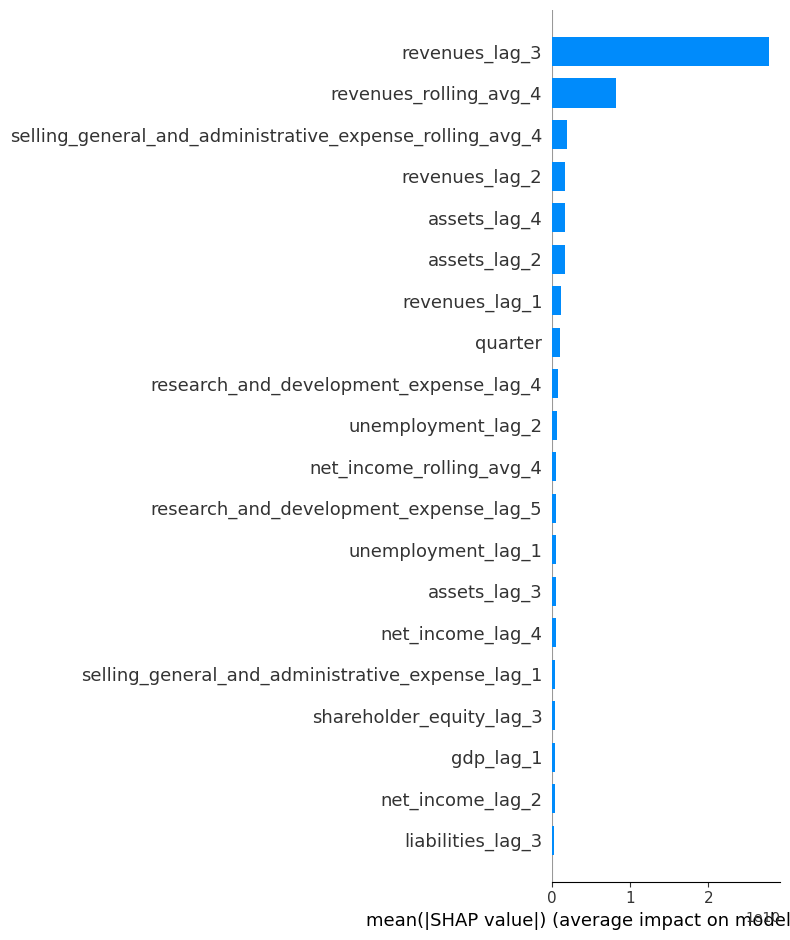

In [6]:
# Combine training and validation sets
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# Train the final median model with the best parameters
final_median_model = xgb.XGBRegressor(objective='reg:squarederror', enable_categorical=True, random_state=42, **best_params)
final_median_model.fit(X_train_full, y_train_full['target_revenue_next_q'])

# Evaluate on the untouched test set to get our final "report card"
test_predictions = final_median_model.predict(X_test)
final_mae = mean_absolute_error(y_test['target_revenue_next_q'], test_predictions)
print(f"\nFinal Model MAE on Test Set: ${final_mae:,.2f}")

# Interpret the final model's predictions on the test set
explainer = shap.TreeExplainer(final_median_model)
shap_values = explainer.shap_values(X_test)
print("\nSHAP Summary Plot (Feature Importance):")
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [7]:
# Combine all historical data for the final training
X_all_history = pd.concat([X_train_full, X_test])
y_all_history = pd.concat([y_train_full, y_test])

# Define the quantiles
lower_alpha, median_alpha, upper_alpha = 0.1, 0.5, 0.9

# Initialize the three final models
model_lower = xgb.XGBRegressor(objective='reg:quantileerror', quantile_alpha=lower_alpha, enable_categorical=True, random_state=42, **best_params)
model_median = xgb.XGBRegressor(objective='reg:quantileerror', quantile_alpha=median_alpha, enable_categorical=True, random_state=42, **best_params)
model_upper = xgb.XGBRegressor(objective='reg:quantileerror', quantile_alpha=upper_alpha, enable_categorical=True, random_state=42, **best_params)

print(f"\nRe-training final models on all {len(X_all_history)} data points...")
model_lower.fit(X_all_history, y_all_history['target_revenue_next_q'])
model_median.fit(X_all_history, y_all_history['target_revenue_next_q'])
model_upper.fit(X_all_history, y_all_history['target_revenue_next_q'])
print("Final models are ready.")

# Prepare the future input data
future_input_df = df.groupby('ticker').last()
future_input_df['prediction_quarter'] = future_input_df['prediction_quarter'] + pd.DateOffset(months=3)
X_future = future_input_df[X_train.columns].copy()
X_future['quarter'] = X_future['quarter'].astype('category')

# Generate the final forecast
future_lower = model_lower.predict(X_future)
future_median = model_median.predict(X_future)
future_upper = model_upper.predict(X_future)

forecast_df = pd.DataFrame({ 'Forecast_Quarter': future_input_df['prediction_quarter'], 'Lower_Bound': future_lower, 'Forecast': future_median, 'Upper_Bound': future_upper }, index=X_future.index)
forecast_df['Lower_Bound'] = forecast_df[['Lower_Bound', 'Forecast', 'Upper_Bound']].min(axis=1)
forecast_df['Upper_Bound'] = forecast_df[['Lower_Bound', 'Forecast', 'Upper_Bound']].max(axis=1)

print("\n--- FINAL REVENUE FORECAST ---")
display(forecast_df)


Re-training final models on all 216 data points...
Final models are ready.

--- FINAL REVENUE FORECAST ---


,Forecast_Quarter,Lower_Bound,Forecast,Upper_Bound
ticker,,,,
AAPL,2025-10-01,7.768057e+10,9.619613e+10,9.619613e+10
GOOGL,2025-10-01,7.868760e+10,1.002910e+11,1.029207e+11
MSFT,2025-10-01,7.485747e+10,7.723743e+10,7.723743e+10


In [8]:
# Manual Save and Log Artifact Workflow ---

# 1. Save the models to local files
model_lower.save_model("model_lower.json")
model_median.save_model("model_median.json")
model_upper.save_model("model_upper.json")
print("\nModels saved to local .json files.")

# 2. Log the files as artifacts to Azure ML
mlflow.set_experiment("Revenue Forecasting")
with mlflow.start_run() as run:
    mlflow.log_params(best_params)
    mlflow.log_metric("final_test_mae", final_mae)
    
    # Log each model file as a separate artifact in its own folder
    mlflow.log_artifact("model_lower.json", "model_lower")
    mlflow.log_artifact("model_median.json", "model_median")
    mlflow.log_artifact("model_upper.json", "model_upper")
    
print(f"\nSuccessfully logged all three models as artifacts in MLflow Run ID: {run.info.run_id}")


Models saved to local .json files.
🏃 View run icy_bag_l4j1rwjd at: https://westus2.api.azureml.ms/mlflow/v1.0/subscriptions/5f163b2e-8558-4d62-b31c-fbf23527e190/resourceGroups/ai-revenue-forecaster/providers/Microsoft.MachineLearningServices/workspaces/mlw-revenue-forecaster/#/experiments/77665c53-43a7-4f14-a996-4fc9152f5311/runs/bb19a745-c958-41d3-8d49-aff409e5f5c2
🧪 View experiment at: https://westus2.api.azureml.ms/mlflow/v1.0/subscriptions/5f163b2e-8558-4d62-b31c-fbf23527e190/resourceGroups/ai-revenue-forecaster/providers/Microsoft.MachineLearningServices/workspaces/mlw-revenue-forecaster/#/experiments/77665c53-43a7-4f14-a996-4fc9152f5311

Successfully logged all three models as artifacts in MLflow Run ID: bb19a745-c958-41d3-8d49-aff409e5f5c2
